In [222]:
from groo.groo import get_root
root_dir = get_root(".root_dir_covid")

import os
print(root_dir)
import sys
sys.path.append(os.path.join(root_dir, "covid-fear", "scripts"))

import numpy as np
import pandas as pd
from cov_functions import *
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
import warnings
import itertools
warnings.filterwarnings('ignore')
from sklearn.linear_model import LinearRegression as lm
from scipy.stats import zscore as zscore_sc
import bambi as bmb
import arviz as az
import bammm_local as mm
import json
import statsmodels.api as sm
import statsmodels.formula.api as smf
from itertools import product, combinations

# load main dataset
df = pd.read_csv(os.path.join(root_dir, "data", "full_dataset_only_complete_based_on_sess_avg.csv"))
df["cases"] = df["cases14_std_unsmooth"]
df["deaths"] = df["deaths14_std_unsmooth"]

trait_factor_names = ["TF3_NegativeAffect", "TF2_PhysiolAnx", "TF1_CognAnxDepr"]
trait_factor_names_short = ["TF3", "TF2", "TF1"]

mapdict = {'TF3_NegativeAffect': 'TF3',
           'TF2_PhysiolAnx': 'TF2', 
           'TF1_CognAnxDepr': 'TF1',
           'stai_ta': "TA",
           'covid_worry': 'Worry', 
           'prob_est': 'Risk',
           'q7_worry_econ_impact': 'EconWorr',
           'q6_apply_soc_dist': 'SocialDist',
           'q6_risk_group': 'RiskGr',
           'avoid_beh': 'Avoidance',
           'avoid_anx': 'AvoidAnx',
           'q6_media_freq_num': 'InforSeek',
           'q6_media_valence': 'MediaVal',
           'q7_period_rel_danger': 'ThreatPerception',
           'deaths': 'Deaths',
           'cases': 'Cases',
           'worryhealth': 'HealthWorry',
           'q6_work_home': "WorkHome",
           'sticsa_som_sa_currsess': "StateSomAnx",
            "covid_thoughts": "CovThoughts", 
            "memory_worry_infected_baselined": "MemWorry", 
            "memory_prob_infected_baselined": "MemProb", 
           }

#vars = ["Avoidance", "InforSeek", "Risk", 
#        "ThreatPerception", "Deaths", "Cases"]

vars = ["Avoidance", "InforSeek", "Risk", 
        "ThreatPerception", "Worry", "AvoidAnx",  "Deaths", "Cases"]

df=df.rename(columns=mapdict)
dfall = df.copy()

df = df.loc[:,vars+["PROLIFICID","session"]]#.set_index("PROLIFICID")

# zscore each variable by session (for regressions)
for v in vars: 
    for s in df.session.unique(): 
      df.loc[df["session"]==s,v] = zscore_sc(np.array(df.loc[df["session"]==s,v]), nan_policy="omit")
    


def demultindex(df):
    df.columns = [ x+"_"+str(y) for x,y in df.columns ]
    return df

# Trait scores in a separate df
df_id = dfall.loc[:,["PROLIFICID"]+trait_factor_names_short].groupby(by="PROLIFICID").mean()

/data/drive/postdoc/Project4_covid


### Control variables 

In [223]:
# size of lag (here fiexed to 1)
win = 1

### Prepare data

In [224]:
tdf = demultindex(df.pivot(columns="session", index="PROLIFICID", values=vars))

## Run regressions

In [225]:
ddf = pd.DataFrame()
for dvidx, dv in enumerate(vars):
    ## Prepare data set 
    
    for s in np.arange(win,20):

        dv_str = dv+"_"+str(s+1)
        ivs_str = [x+"_"+str(s) for x in vars]
        ttf = tdf.loc[:,[dv_str]+ivs_str].dropna()
        mod = sm.OLS(ttf[dv_str], ttf.loc[:,ivs_str])
        res = mod.fit()

        cdf = res.conf_int(alpha=0.05)
        cdf.columns = ["CI5", "CI95"]
        cdf["beta"] = res.params
        cdf["dv"] = dv 
        cdf["p"] = round(res.pvalues, 4)
        cdf["session"] =s+1
        cdf["iv"] = cdf.index.str.split("_").str[0]

        ddf = pd.concat([ddf, cdf.reset_index()])

# Map variables to IDs
var_to_id = {var: i for i, var in enumerate(vars)}

# Create dv_id and iv_id columns
ddf['dv_id'] = ddf['dv'].map(var_to_id)
ddf['iv_id'] = ddf['iv'].map(var_to_id)

In [226]:
ddf_unfiltered= ddf.copy()
ddf = ddf.loc[(ddf['iv'] != ddf["dv"]) & (ddf["dv"]!="Deaths") & (ddf["dv"]!="Cases") & (ddf["p"]<0.05),]


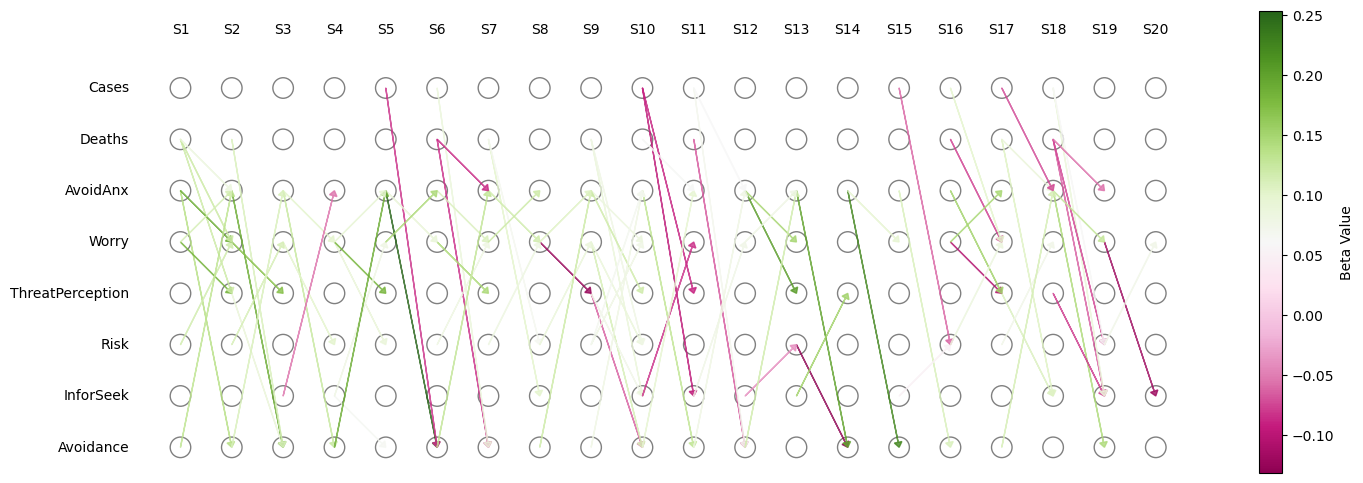

In [227]:
import matplotlib.cm as cm
import matplotlib.colors as mcolors

# Normalize beta values for the colormap
norm = mcolors.Normalize(vmin=ddf['beta'].min(), vmax=ddf['beta'].max())
cmap = cm.get_cmap('PiYG')

#norm = mcolors.TwoSlopeNorm(vmin=wave_ddf['beta'].min(), vcenter=0, vmax=wave_ddf['beta'].max())


# Grid settings
n_sessions = 20
n_vars = len(vars)
circle_radius = 0.2
arrow_scale = 0.5

fig, ax = plt.subplots(figsize=(20, 6))

# Draw circles
for t in range(n_sessions):
    for i in range(n_vars):
        ax.add_patch(plt.Circle((t, i), circle_radius, color='gray', fill=False))

# Draw arrows
for index, row in ddf.iterrows():
    t = row['session'] - 2
    dv_id = row['dv_id']
    iv_id = row['iv_id']
    beta = row['beta']
    color = cmap(norm(beta))
    ax.arrow(t, iv_id, 1, dv_id - iv_id, head_width=0.15, head_length=0.1, fc=color, ec=color, length_includes_head=True, alpha=0.8)

# Add variable labels on the left
for i, var in enumerate(vars):
    ax.text(-1, i, var, verticalalignment='center', horizontalalignment='right')

# Add session numbers above each column
for t in range(n_sessions):
    ax.text(t, n_vars, f'S{t+1}', horizontalalignment='center', verticalalignment='bottom')

# Setting the limits and aspect ratio
ax.set_xlim(-1.5, n_sessions - 0.5)
ax.set_ylim(-0.5, n_vars + 0.5)
ax.set_aspect('equal')

# Hide the axes
ax.axis('off')

# Add colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, orientation='vertical')
cbar.set_label('Beta Value')

plt.show()

### Plot by wave

In [234]:
ddf_unfiltered = ddf_unfiltered.loc[(ddf_unfiltered['iv'] != ddf_unfiltered["dv"]) & (ddf_unfiltered["dv"]!="Deaths") & (ddf_unfiltered["dv"]!="Cases"),]
# Create the "wave" variable
def assign_wave(session):
    if 1 <= session <= 6:
        return "first wave"
    elif 7 <= session <= 12:
        return "no wave"
    else:
        return "autumn wave"

# Aggregate the beta values by wave
ddf_unfiltered['wave'] = ddf_unfiltered['session'].apply(assign_wave)

from scipy import stats

# Grouping by wave and calculating mean beta, t-value, df, and p-value
def t_test(group):
    t_stat, p_val = stats.ttest_1samp(group['beta'], 0)
    df = len(group['beta']) - 1
    return pd.Series({'beta': group['beta'].mean(), 't_value': t_stat, 'df': df, 'p_value': p_val})

wave_ddf = ddf_unfiltered.groupby(['wave', 'dv', 'iv', 'dv_id', 'iv_id']).apply(t_test).reset_index()
#wave_ddf = wave_ddf.loc[wave_ddf["p_value"]<0.05, ]

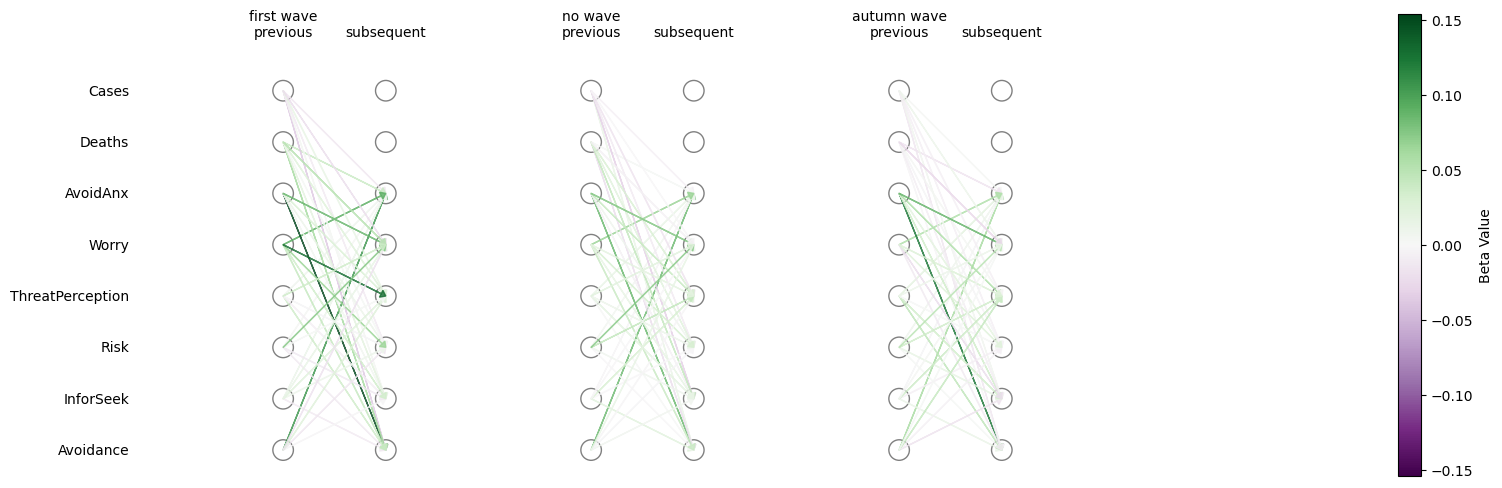

In [235]:


# Normalize beta values for the colormap, centered on 0 with symmetrical limits
max_abs_beta = max(abs(wave_ddf['beta'].min()), abs(wave_ddf['beta'].max()))
norm = mcolors.TwoSlopeNorm(vmin=-max_abs_beta, vcenter=0, vmax=max_abs_beta)

# Create a custom colormap
cmap = plt.get_cmap('PRGn')

# Grid settings
waves = ["first wave", "no wave", "autumn wave"]
n_waves = len(waves)
n_vars = len(vars)
circle_radius = 0.2
arrow_scale = 0.5

# Adjust figure size for wider plot
fig, ax = plt.subplots(figsize=(n_waves * 12, 6))

# Draw circles for previous and subsequent columns
for w, wave in enumerate(waves):
    base_x = w * 6  # Increased gap between waves
    for i in range(n_vars):
        ax.add_patch(plt.Circle((base_x, i), circle_radius, color='gray', fill=False))
        ax.add_patch(plt.Circle((base_x + 2, i), circle_radius, color='gray', fill=False))

# Draw arrows within each wave
for index, row in wave_ddf.iterrows():
    wave_from = row['wave']
    w = waves.index(wave_from)
    base_x = w * 6
    dv_id = row['dv_id']
    iv_id = row['iv_id']
    beta = row['beta']
    color = cmap(norm(beta))
    ax.arrow(base_x, iv_id, 2, dv_id - iv_id, head_width=0.15, head_length=0.1, fc=color, ec=color, length_includes_head=True, alpha=0.8)

# Add variable labels on the left
for i, var in enumerate(vars):
    ax.text(-3, i, var, verticalalignment='center', horizontalalignment='right')

# Add wave names and column labels
for w, wave in enumerate(waves):
    base_x = w * 6
    ax.text(base_x, n_vars, wave + "\nprevious", horizontalalignment='center', verticalalignment='bottom')
    ax.text(base_x + 2, n_vars, "subsequent", horizontalalignment='center', verticalalignment='bottom')

# Setting the limits and aspect ratio
ax.set_xlim(-4, n_waves * 6 + 1)
ax.set_ylim(-0.5, n_vars + 0.5)
ax.set_aspect('equal')

# Hide the axes
ax.axis('off')

# Add colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, orientation='vertical')
cbar.set_label('Beta Value')

plt.show()

In [230]:
wave_ddf

wave        dv                iv  dv_id  iv_id      beta  \
0    autumn wave  AvoidAnx         Avoidance      5      0  0.060284   
1    autumn wave  AvoidAnx             Cases      5      7  0.002741   
2    autumn wave  AvoidAnx            Deaths      5      6 -0.015831   
3    autumn wave  AvoidAnx         InforSeek      5      1 -0.002626   
4    autumn wave  AvoidAnx              Risk      5      2  0.008423   
..           ...       ...               ...    ...    ...       ...   
121      no wave     Worry             Cases      4      7 -0.000869   
122      no wave     Worry            Deaths      4      6 -0.005657   
123      no wave     Worry         InforSeek      4      1 -0.001019   
124      no wave     Worry              Risk      4      2  0.073436   
125      no wave     Worry  ThreatPerception      4      3  0.021284   

       t_value   df   p_value  
0     4.410607  7.0  0.003117  
1     0.189899  7.0  0.854777  
2    -0.950739  7.0  0.373400  
3    -0.238450  7.0  0.818362  
4     1.308312  7.0  0.232087  
..         ...  ...       ...  
121  -0.057010  5.0  0.956745  
122  -0.466053  5.0  0.660776  
123  -0.044477  5.0  0.966246  
124  11.666718  5.0  0.000081  
125   1.527626  5.0  0.187141  

[126 rows x 9 columns]